In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import re
import datetime as dt

# # visualization
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

# Writing multiple dataframes to worksheets using Pandas and XlsxWriter
import xlsxwriter
import glob

# !pip install xlsxwriter
# !pip install glob

In [2]:
xls = pd.ExcelFile(r'C:\Users\u1-510\Desktop\Python\Untitled Folder\Analysis_Сonversion.xlsx')
df = pd.read_excel(xls, 'Segment')

In [3]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [4]:
df = df.query("(Geo=='KZ') | (Geo=='RU') | (Geo=='UA')")

In [5]:
df = df.query("Network=='Видео на YouTube'")

In [6]:
# Только номер креатива
df['Creo_group'] = df['Creo'].str.split('(\d+)([A-Za-z]+)', expand=True).loc[:,[1]]

In [7]:
def ftd_target(el):
    if el > 0:
        return 1
    else:
        return 0

In [8]:
df['Target'] = df['FTD'].map(ftd_target)

<AxesSubplot:>

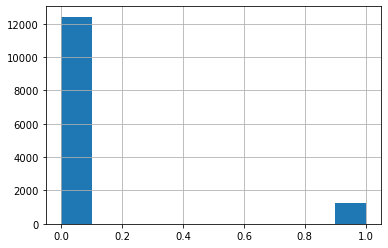

In [9]:
df['Target'].hist()

In [10]:
df.Target.value_counts().reset_index()

,index,Target
0,0,12419
1,1,1261


In [11]:
tgt_train = df.copy()

In [12]:
tgt_train['Campaign'] = tgt_train['ADS'].astype(str) + ' ' +  tgt_train['Camp'].astype(str) + ' ' + tgt_train['Ad_group'].astype(str) + ' ' + tgt_train['Date'].astype(str)

In [13]:
tgt_train = tgt_train.reset_index(drop=True)

In [14]:
# # Словарь класификации
# codes_cats = tgt_train.Campaign.astype('category')
# dict_cats = dict(enumerate(codes_cats.cat.categories))

In [15]:
# # Присвоенные cat.codes
# tgt_train['ID'] = tgt_train.Campaign.astype('category').cat.codes

# # Розшифровка
# #df_group['level_back'] = df_group['ID'].map(dict_cats)

In [16]:
tgt_train.columns

Index(['Geo', 'Network', 'Optimization', 'Creo', 'Brand',
       'Ad_group_target_CPA', 'ADS', 'Camp', 'Ad_group', 'App', 'Date',
       'Cost_USD', 'Cost', 'Show', 'Clicks', 'Install', 'Firstopen',
       'Registration', 'FTD', 'CPM', 'CPM_segment', 'CPC', 'CPC_segment',
       'Inst_cost', 'Inst_cost_segment', 'Inst_cost_segment_AU_DE',
       'Open_cost', 'Open_cost_segment', 'Open_cost_segment_AU_DE', 'Reg_cost',
       'Reg_cost_segment', 'Reg_cost_segment_AU_DE', 'FTD_cost', 'CTR',
       'CTR_cost_segment', 'CR_click_inst', 'CR_click_inst_segment',
       'CR_inst_open', 'CR_inst_open_segment', 'CR_open_reg',
       'CR_open_reg_segment', 'CR_reg_ftd', 'CR_reg_ftd_segment',
       'CPA_segment', 'Creo_group', 'Target', 'Campaign'],
      dtype='object')

In [17]:
tgt_train.drop(['Geo', 'Network', 'Optimization', 'Creo', 'Brand', 'App', 'Date', 'ADS', 'Camp', 'Ad_group',
       'Ad_group_target_CPA', 'Cost_USD', 'Cost', 'Show', 'Clicks', 'Install', 'Firstopen',
       'Registration', 'FTD', 'Inst_cost_segment_AU_DE', 'Open_cost_segment_AU_DE', 
                'Reg_cost_segment_AU_DE', 'FTD_cost', 'CR_reg_ftd', 'CR_reg_ftd_segment', 'Campaign', 'CPA_segment'], axis=1, inplace=True)

In [18]:
tgt_train.columns

Index(['CPM', 'CPM_segment', 'CPC', 'CPC_segment', 'Inst_cost',
       'Inst_cost_segment', 'Open_cost', 'Open_cost_segment', 'Reg_cost',
       'Reg_cost_segment', 'CTR', 'CTR_cost_segment', 'CR_click_inst',
       'CR_click_inst_segment', 'CR_inst_open', 'CR_inst_open_segment',
       'CR_open_reg', 'CR_open_reg_segment', 'Creo_group', 'Target'],
      dtype='object')

In [19]:
tgt_train.CR_inst_open.describe()

count    13680.000000
mean         0.810386
std          1.176064
min          0.000000
25%          0.000000
50%          0.000000
75%          1.400000
max         25.000000
Name: CR_inst_open, dtype: float64

In [20]:
tgt_train.Reg_cost.describe()

count    13680.000000
mean         2.123319
std          4.937910
min          0.000000
25%          0.000000
50%          0.000000
75%          2.510000
max        161.710000
Name: Reg_cost, dtype: float64

In [21]:
tgt_train.Inst_cost.describe()

count    13680.000000
mean         0.756950
std          1.234538
min          0.000000
25%          0.000000
50%          0.240000
75%          1.140000
max         23.450000
Name: Inst_cost, dtype: float64

## Categorical variable encoding

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
cat = ['CPM_segment', 'CPC_segment', 'Inst_cost_segment',  'Open_cost_segment',  'Reg_cost_segment', 
                       'CTR_cost_segment', 'CR_click_inst_segment',  'CR_inst_open_segment', 'CR_open_reg_segment']

In [24]:
x_cat = pd.get_dummies(tgt_train[cat])

## Standardization

In [25]:
from sklearn.preprocessing import StandardScaler
attrs_num = ['CPM', 'CPC', 'CTR', 'Inst_cost', 'Open_cost', 'Reg_cost', 'CR_click_inst', 'CR_inst_open', 'CR_open_reg']
scl = StandardScaler()
x_num = pd.DataFrame(scl.fit_transform(tgt_train[attrs_num]), columns=attrs_num)

In [26]:
train_data = pd.concat([tgt_train[['Target']], x_num], axis=1)

In [27]:
# train_data = tgt_train[['Target', 'CPM', 'CPC', 'CTR', 'Inst_cost', 'Open_cost', 'Reg_cost', 'CR_click_inst', 'CR_inst_open', 'CR_open_reg']]

## Modeling

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score , accuracy_score, precision_score

In [28]:
X = train_data.drop("Target",axis=1)
y = train_data['Target']

print(X.shape, y.shape, train_data.shape)

(13680, 9) (13680,) (13680, 10)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=31)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [96]:
model = GaussianNB(priors=[0.9, 0.1])

In [97]:
model.fit(X_train,y_train)
predict=model.predict(X_test)

In [98]:
print(accuracy_score(y_test,predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

0.7509746588693957
[[2767  952]
 [  70  315]]
              precision    recall  f1-score   support

           0       0.98      0.74      0.84      3719
           1       0.25      0.82      0.38       385

    accuracy                           0.75      4104
   macro avg       0.61      0.78      0.61      4104
weighted avg       0.91      0.75      0.80      4104



In [100]:
model2 = GaussianNB(priors=[0.9, 0.1])

In [101]:
model2.fit(X,y)

GaussianNB(priors=[0.9, 0.1])

In [105]:
import pickle

In [106]:
file_name = "GaussianNB.pkl"
with open(file_name, "wb") as open_file:
    pickle.dump(model2, open_file)

In [107]:
with open("GaussianNB.pkl", 'rb') as open_file:
    loaded_classifier = pickle.load(open_file)

print(loaded_classifier)

GaussianNB(priors=[0.9, 0.1])
